# 이미지 유사도 검색을 위한 메트릭 학습

**저자:** [맷 켈시](https://twitter.com/mat_kelcey)<br>
**만든 날짜:** 2020/06/05<br>
**최종 수정 날짜:** 2020/06/09<br>
**설명:** CIFAR-10 이미지에서 유사도 메트릭 학습을 사용하는 예.

## 개요

메트릭 학습은 학습 계획에 정의된 "유사한" 입력이 서로 가까이 위치하도록 입력을 고차원 공간에 포함할 수 있는 모델을 학습하는 것을 목표로 합니다. 이러한 모델은 일단 훈련되면 그러한 유사성이 유용한 다운스트림 시스템에 대한 임베딩을 생성할 수 있습니다. 예를 들어 검색을 위한 순위 신호 또는 다른 지도 문제에 대한 사전 훈련된 임베딩 모델의 형태가 있습니다.

메트릭 학습에 대한 자세한 개요는 다음을 참조하세요.

* [메트릭 학습이란?](http://contrib.scikit-learn.org/metric-learn/introduction.html)
* ["메트릭 학습을 위한 교차 엔트로피 사용" 튜토리얼](https://www.youtube.com/watch?v=Jb4Ewl5RzkI)


## Setup


In [65]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers


## 데이터세트

이 예에서는 다음을 사용할 것입니다.
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 데이터셋.


In [69]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)
x_train = x_train.astype("float32") / 255.0
print(y_train.shape)
y_train = np.squeeze(y_train)
print(y_train.shape)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)
print(y_test.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(50000,)
(10000,)


데이터 세트를 이해하기 위해 25개의 무작위 예제로 구성된 그리드를 시각화할 수 있습니다.



(5, 5)
(5, 5, 32, 32, 3)


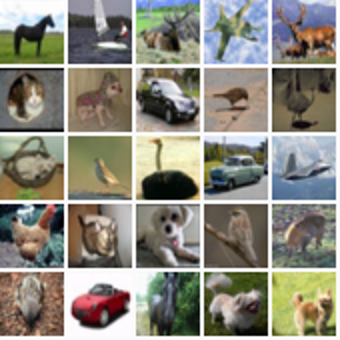

In [82]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


# Show a collage of 5x5 random images.
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
print(sample_idxs.shape)
examples = x_train[sample_idxs]
print(examples.shape)
show_collage(examples)


메트릭 학습은 훈련 데이터를 명시적인 `(X, y)` 쌍으로 제공하지 않고 대신 유사성을 표현하려는 방식으로 관련된 여러 인스턴스를 사용합니다.
이 예에서는 유사성을 나타내기 위해 동일한 클래스의 인스턴스를 사용합니다. 단일 훈련 인스턴스는 하나의 이미지가 아니라 동일한 클래스의 이미지 쌍입니다.
이 쌍의 이미지를 참조할 때 'anchor'(임의로 선택된 이미지)와 'positive'(동일한 클래스의 또 다른 무작위로 선택된 이미지)의 일반적인 메트릭 학습 이름을 사용합니다.

이를 용이하게 하려면 클래스에서 해당 클래스의 인스턴스로 매핑하는 조회 형식을 구축해야 합니다. 훈련용 데이터를 생성할 때 이 조회에서 샘플링합니다.


In [83]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [88]:
type(class_idx_to_train_idxs[1])

list

이 예에서 우리는 훈련에 대한 가장 간단한 접근 방식을 사용하고 있습니다. 배치는 클래스 전체에 퍼져 있는 `(앵커, 포지티브)` 쌍으로 구성됩니다. 학습의 목표는 앵커와 포지티브 쌍을 배치의 다른 인스턴스에서 더 가깝게, 더 멀리 이동시키는 것입니다. 이 경우 배치 크기는 클래스 수에 따라 결정됩니다. CIFAR-10의 경우 이것은 10입니다.


In [89]:
num_classes = 10


class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x



다른 콜라주에서 배치를 시각화할 수 있습니다. 맨 위 행은 10개 클래스에서 무작위로 선택된 앵커를 보여주고 맨 아래 행은 해당하는 10개의 긍정을 보여줍니다.


(2, 10, 32, 32, 3)


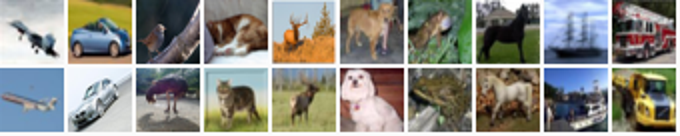

In [91]:
examples = next(iter(AnchorPositivePairs(num_batchs=1)))
print(examples.shape)
show_collage(examples)


## 임베딩 모델

먼저 앵커와 포지티브를 모두 포함하고 쌍별 내적을 소프트맥스에 대한 로짓으로 사용하는 'train_step'으로 사용자 정의 모델을 정의합니다.


In [97]:

class EmbeddingModel(keras.Model):
    def train_step(self, data):    # (2,10,32,32,3)
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]  # (10,32,32,3) , (10,32,32,3)

        with tf.GradientTape() as tape:
            # 모델을 통해 앵커와 포지티브를 모두 실행합니다.
            anchor_embeddings = self(anchors, training=True)      # (10,8)
            positive_embeddings = self(positives, training=True)  # (10,8)

            # 앵커와 포지티브 사이의 코사인 유사도를 계산합니다. 
            # 그들이 정규화되었기 때문에 이것은 단지 pair wise 내적입니다.
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # 이것을 로짓으로 사용하려고 하므로 온도에 따라 크기를 조정합니다.
            # 이 값은 일반적으로 하이퍼 매개변수로 선택됩니다.
            temperature = 0.2
            similarities /= temperature

            # 우리는 이러한 유사성을 softmax에 대한 로짓으로 사용합니다. 
            # 이 호출에 대한 레이블은 앵커/양수 쌍에 해당하는 주 대각선 값이 
            # 높기를 원하기 때문에 [0, 1, 2, ..., num_classes] 시퀀스일 뿐입니다. 
            # 이 손실은 앵커/양성 쌍에 대한 임베딩을 함께 이동하고 다른 모든 쌍을 따로 이동시킵니다.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # 그라디언트를 계산하고 옵티마이저를 통해 적용합니다.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # 메트릭을 업데이트하고 반환합니다(특히 손실 값에 대한 메트릭).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}



다음으로 이미지에서 임베딩으로 매핑되는 아키텍처를 설명합니다. 이 모델은 단순히 임베딩 공간에 대한 최종 선형 투영과 함께 전역 풀링이 뒤따르는 2d 컨볼루션 시퀀스로 구성됩니다. 메트릭 학습에서 흔히 볼 수 있는 것처럼 임베딩을 정규화하여 유사성을 측정하기 위해 간단한 내적을 사용할 수 있습니다. 단순함을 위해 이 모델은 의도적으로 작습니다.


In [98]:
inputs = layers.Input(shape=(height_width, height_width, 3))                  
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)

In [99]:
model.summary()
print(x_train.shape)
model(x_train[:1,:,:,:])

Model: "embedding_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 15, 15, 32)        896       
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_35 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 global_average_pooling2d_11  (None, 128)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 8)                 1032      
                                                

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.16538647, -0.3330262 ,  0.2576154 ,  0.06099967, -0.16858828,
         0.26829302, -0.8309072 ,  0.02905365]], dtype=float32)>

마지막으로 훈련을 진행합니다. Google Colab GPU 인스턴스에서 이 작업은 약 1분 정도 걸립니다.


Epoch 1/20
1000/1000 [==============================] - 3s 3ms/step - loss: 2.2536
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 2.1575
Epoch 3/20
1000/1000 [==============================] - 3s 3ms/step - loss: 2.0752
Epoch 4/20
1000/1000 [==============================] - 3s 3ms/step - loss: 2.0300
Epoch 5/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9984
Epoch 6/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9602
Epoch 7/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9326
Epoch 8/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.9070
Epoch 9/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8827
Epoch 10/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8548
Epoch 11/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8224
Epoch 12/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1.8054
E

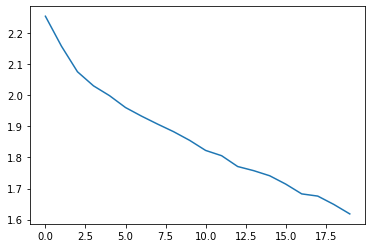

In [100]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

history = model.fit(AnchorPositivePairs(num_batchs=1000), epochs=20)

plt.plot(history.history["loss"])
plt.show()


## 테스트

이 모델을 테스트 세트에 적용하고 임베딩 공간에서 가까운 이웃을 고려하여 이 모델의 품질을 검토할 수 있습니다.

먼저 테스트 세트를 포함하고 모든 인접 이웃을 계산합니다. 임베딩이 단위 길이이기 때문에 내적을 통해 코사인 유사도를 계산할 수 있음을 기억하십시오.


In [101]:
a = np.array([[1,2,3],
              [4,5,6]])
b = np.array([[1,1,1],
              [2,2,2]])
c = np.einsum("ae,be->ab", a, b)
print(c)

[[ 6 12]
 [15 30]]


In [105]:
near_neighbours_per_example = 10

print(x_test.shape)
embeddings = model.predict(x_test)
print(embeddings.shape)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
print(gram_matrix.shape)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]
print(near_neighbours.shape)

(10000, 32, 32, 3)
(10000, 8)
(10000, 10000)
(10000, 11)


이러한 임베딩을 시각적으로 확인하기 위해 5개의 무작위 예제에 대해 가까운 이웃의 콜라주를 만들 수 있습니다. 아래 이미지의 첫 번째 열은 무작위로 선택된 이미지이고, 다음 10개 열은 유사도 순으로 가장 가까운 이웃을 보여줍니다.


(5, 11, 32, 32, 3)


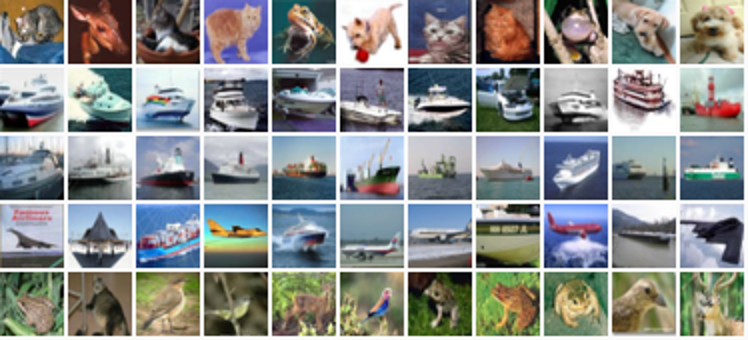

In [106]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

print(examples.shape)
show_collage(examples)


또한 혼동 행렬의 관점에서 인접 이웃의 정확성을 고려하여 성능을 정량적으로 볼 수 있습니다.

10개의 클래스 각각에서 10개의 예제를 샘플링하고 가까운 이웃을 예측의 한 형태로 고려하겠습니다. 즉, 예제와 가까운 이웃이 동일한 클래스를 공유합니까?

우리는 각 동물 등급이 일반적으로 잘 수행되고 다른 동물 등급과 가장 혼동되는 것을 관찰했습니다. 차량 등급은 동일한 패턴을 따릅니다.

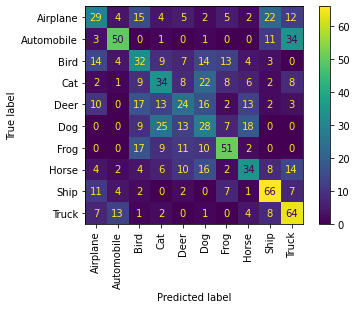

In [107]:
confusion_matrix = np.zeros((num_classes, num_classes))

# 각 클래스마다.
for class_idx in range(num_classes):
    # 10가지 예를 고려합니다.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # 그리고 가까운 이웃의 클래스를 셉니다.
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# 혼동 행렬을 표시합니다.
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()
